# Homework 1

This homework will cover convolutions and Canny edge detectors.

*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*


## Setup

In [414]:
# Setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
from skimage import io


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 18.0) # set the default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----
## Part 1: Convolutions (50 points)


### 1.1 Commutative Property (5 points)
Recall that the convolution of an image $f:\mathbb{R}^2\rightarrow \mathbb{R}$ and a kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$ is defined as follows:
$$(f*h)[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]$$

Or equivalently,
\begin{align}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty h[i,j]\cdot f[m-i,n-j]\\
&= (h*f)[m,n]
\end{align}

Show that this is true (i.e. prove that the convolution operator is commutative: $f*h = h*f$).

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

\begin{align}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]\\
&= \sum_{u=-\infty}^\infty\sum_{v=-\infty}^\infty f[m-u,n-v]\cdot h[u,v]\\
&= \sum_{u=-\infty}^\infty\sum_{v=-\infty}^\infty h[u,v]\cdot f[m-u,n-v]\\
&= (h*f)[m,n]
\end{align}

### 1.2 Shift Invariance (5 points)
Let $f$ be a function $\mathbb{R}^2\rightarrow\mathbb{R}$. Consider a system $f\xrightarrow{s}g$, where $g=(f*h)$ with some kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$. Also consider functions $f'[m,n] = f[m-m_0, n-n_0]$ and $g'[m,n] = g[m-m_0, n-n_0]$.  

Show that $S$ defined by any kernel $h$ is a shift invariant system by showing that $g' = (f'*h)$.

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*
\begin{align}
(f*h)[m,n] = \sum_{i=-\infty}^{\infty}\sum_{j=-\infty}^{\infty}
f[i,j]\,h[m-i,n-j].
\end{align}

\begin{aligned}
(f'*h)[m,n]
&= \sum_{u=-\infty}^{\infty}\sum_{v=-\infty}^{\infty}
f'[u,v]\,h[m-u,\,n-v] \\
&= \sum_{u}\sum_{v} f[u-m_0,\,v-n_0]\,h[m-u,\,n-v].
\end{aligned}

\begin{aligned}
(f'*h)[m,n]
&= \sum_{i=-\infty}^{\infty}\sum_{j=-\infty}^{\infty}
f[i,j]\,h\big(m-(i+m_0),\,n-(j+n_0)\big) \\
&= \sum_{i}\sum_{j} f[i,j]\,h\big((m-m_0)-i,\,(n-n_0)-j\big) \\
&= (f*h)[m-m_0,\,n-n_0].
\end{aligned}

\begin{aligned}
(f*h)[m-m_0,\,n-n_0] = g[m-m_0,\,n-n_0] = g'[m,n].
\end{aligned}



### 1.3 Linearity (10 points)

Recall that a system S is considered a linear system if and only if it satisfies the superposition property. In mathematical terms, a (function) S is a linear invariant system iff it satisfies:

$$
S\{\alpha f_1[n,m] + \beta f_2[n,m]\} = \alpha S\{f_1[n,m]\} + \beta S\{f_2[n,m]\}
$$

Let $f_1$ and $f_2$ be functions $\mathbb{R}^2\rightarrow\mathbb{R}$. Consider a system $f\xrightarrow{s}g$, where $g=(f*h)$ with some kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$.  

Prove that $S$ defined by any kernel $h$ is linear by showing that the superposition property holds.

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

\begin{aligned}
\big((\alpha f_1 + \beta f_2)*h\big)[m,n]
&= \sum_{i=-\infty}^{\infty}\sum_{j=-\infty}^{\infty} \big(\alpha f_1[i,j] + \beta f_2[i,j]\big) h[m-i,n-j] \\
&= \sum_{i}\sum_{j} \alpha f_1[i,j]\,h[m-i,n-j] + \sum_{i}\sum_{j} \beta f_2[i,j]\,h[m-i,n-j] \\
&= \alpha \sum_{i}\sum_{j} f_1[i,j]\,h[m-i,n-j] + \beta \sum_{i}\sum_{j} f_2[i,j]\,h[m-i,n-j] \\
&= \alpha (f_1*h)[m,n] + \beta (f_2*h)[m,n].
\end{aligned}


### 1.4 Implementation (30 points)

In this section, you will implement two versions of convolution:
- `conv_nested`
- `conv_fast`

First, run the code cell below to load the image to work with.

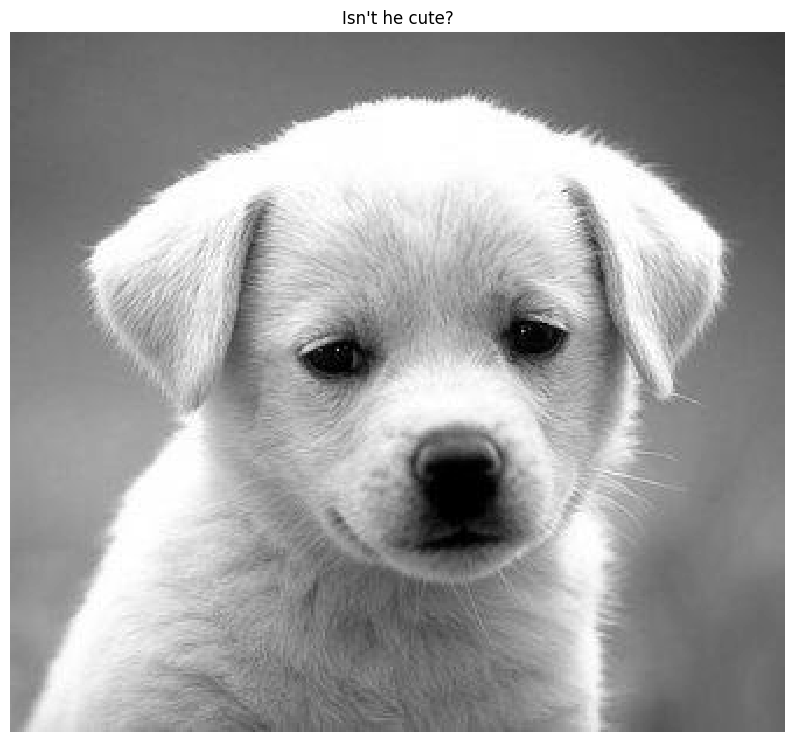

In [415]:
# Open image as grayscale
img = io.imread('dog.jpg', as_gray=True)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title("Isn't he cute?")
plt.show()

Now, implement the function **`conv_nested`** below. This is a naive implementation of convolution which uses 4 nested for-loops. It takes an image $f$ and a kernel $h$ as inputs and outputs the convolved image $(f*h)$ that has the same shape as the input image. This implementation should take a few seconds to run.

*- Hint: It may be easier to implement $(h*f)$*

We'll first test your `conv_nested` function on a simple input.

In [416]:
def conv_nested(image, kernel):
    """A naive implementation of convolution filter.

    This is a naive implementation of convolution using 4 nested for-loops.
    This function computes convolution of an image with a kernel and outputs
    the result that has the same shape as the input image.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk). Dimensions will be odd.

    Returns:
        out: numpy array of shape (Hi, Wi).
    """

    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    k_radius = [Hk // 2, Wk // 2]

    for row in range(Hi):
        for col in range(Wi):
            for k in range(-k_radius[0], k_radius[0] + 1):
                for l in range(-k_radius[1], k_radius[1] + 1):
                    if 0 <= row + k < Hi and 0 <= col + l < Wi:
                        out[row, col] += kernel[Hk - 1 - k - k_radius[0] , Wk - 1 - l - k_radius[1]] * image[row + k, col + l]

    return out

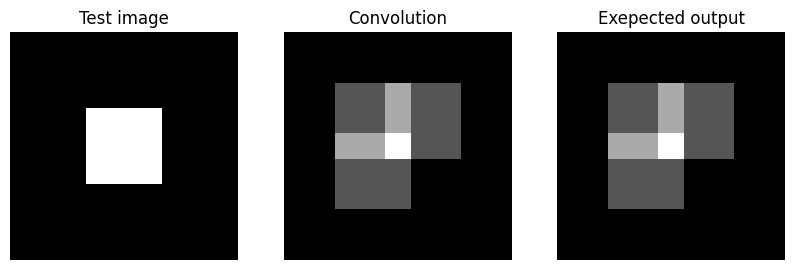

In [417]:
# Simple convolution kernel
kernel = np.array(
[
    [1,0,1],
    [0,0,0],
    [1,0,0]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[5:, 5:] = 0
expected_output[4, 2:5] = 2
expected_output[2:5, 4] = 2
expected_output[4, 4] = 3

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

# Test if the output matches the expected output
assert np.max(test_output - expected_output) < 1e-10, "Your solution is not correct."

Now let's test your `conv_nested` function on a real image.

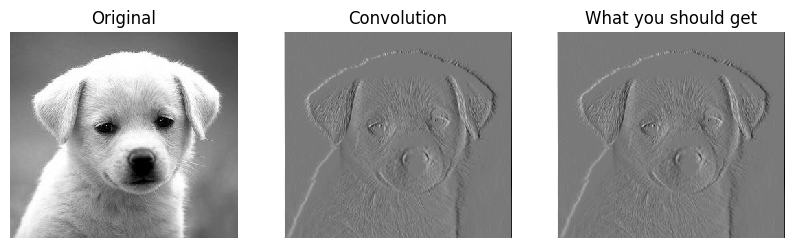

In [418]:
# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

out = conv_nested(img, kernel)

# Plot original image
plt.subplot(1,3,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(out)
plt.title('Convolution')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('convolved_dog.png', as_gray=True)
plt.subplot(1,3,3)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Let us implement a more efficient version of convolution using array operations in numpy. As shown in the lecture, a convolution can be considered as a sliding window that computes sum of the pixel values weighted by the flipped kernel. The faster version will i) zero-pad an image, ii) flip the kernel horizontally and vertically, and iii) compute weighted sum of the neighborhood at each pixel.

First, implement the function **`zero_pad`** below.


In [419]:
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]] of shape (3, 5)

    Args:
        image: numpy array of shape (H, W).
        pad_width: width of the zero padding (left and right padding).
        pad_height: height of the zero padding (bottom and top padding).

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width).
    """

    return np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 'constant', constant_values = 0)

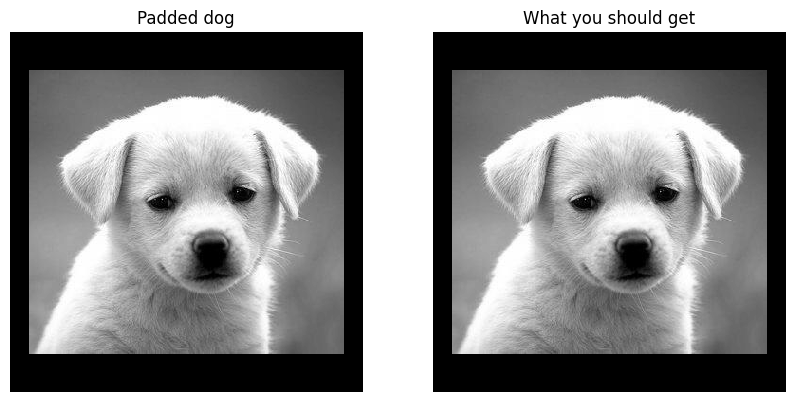

In [420]:
pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)

# Plot your padded dog
plt.subplot(1,2,1)
plt.imshow(padded_img)
plt.title('Padded dog')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('padded_dog.jpg', as_gray=True)
plt.subplot(1,2,2)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Next, complete the function **`conv_fast`** below using `zero_pad`. Run the code below to compare the outputs by the two implementations. `conv_fast` should run noticeably faster than `conv_nested`.  


In [421]:
def conv_fast(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape

    pad_h, pad_w = Hk // 2, Wk // 2

    kernel = np.flip(kernel) # Flip the kernel

    padded = zero_pad(image, pad_h, pad_w) # Pad the image

    out = np.zeros((Hi, Wi))

    for i in range(Hi):
        for j in range(Wi):
            region = padded[i:i+Hk, j:j+Wk]
            out[i, j] = np.sum(region * kernel)

    return out

conv_nested: took 0.564943 seconds.
conv_fast: took 0.387258 seconds.


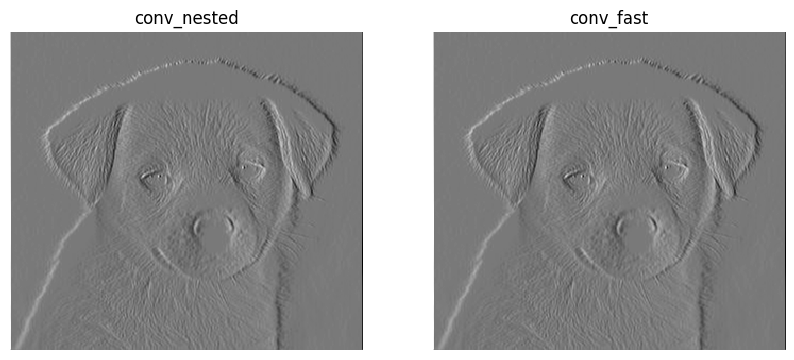

In [422]:
t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_nested = conv_nested(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Make sure that the two outputs are the same
if not (np.max(out_fast - out_nested) < 1e-10):
    print("Different outputs! Check your implementation.")

---
## Part 2: Cross-correlation (30 points)

Cross-correlation of an image $f$ with a template $g$ is defined as follows:
$$(g ** f)[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty g[i,j]\cdot f[m + i,n + j]$$

### 2.1 Template Matching with Cross-correlation (12 points)
Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

Luckily, you have learned in CS131 that cross-correlation can be used for template matching: a template $g$ is multiplied with regions of a larger image $f$ to measure how similar each region is to the template.

The template of a product (`template.jpg`) and the image of shelf (`shelf.jpg`) is provided. We will use cross-correlation to find the product in the shelf.

Implement **`cross_correlation`** function below and run the code below.

*- Hint: you may use the `conv_fast` function you implemented in the previous question.*

In [423]:
def cross_correlation(f, g):
    """ Cross-correlation of image f and template g.

    Hint: use the conv_fast function defined above.

    Args:
        f: numpy array of shape (Hf, Wf).
        g: numpy array of shape (Hg, Wg).

    Returns:
        out: numpy array of shape (Hf, Wf).
    """

    g_flipped_back = np.flip(g)
    return conv_fast(f, g_flipped_back)

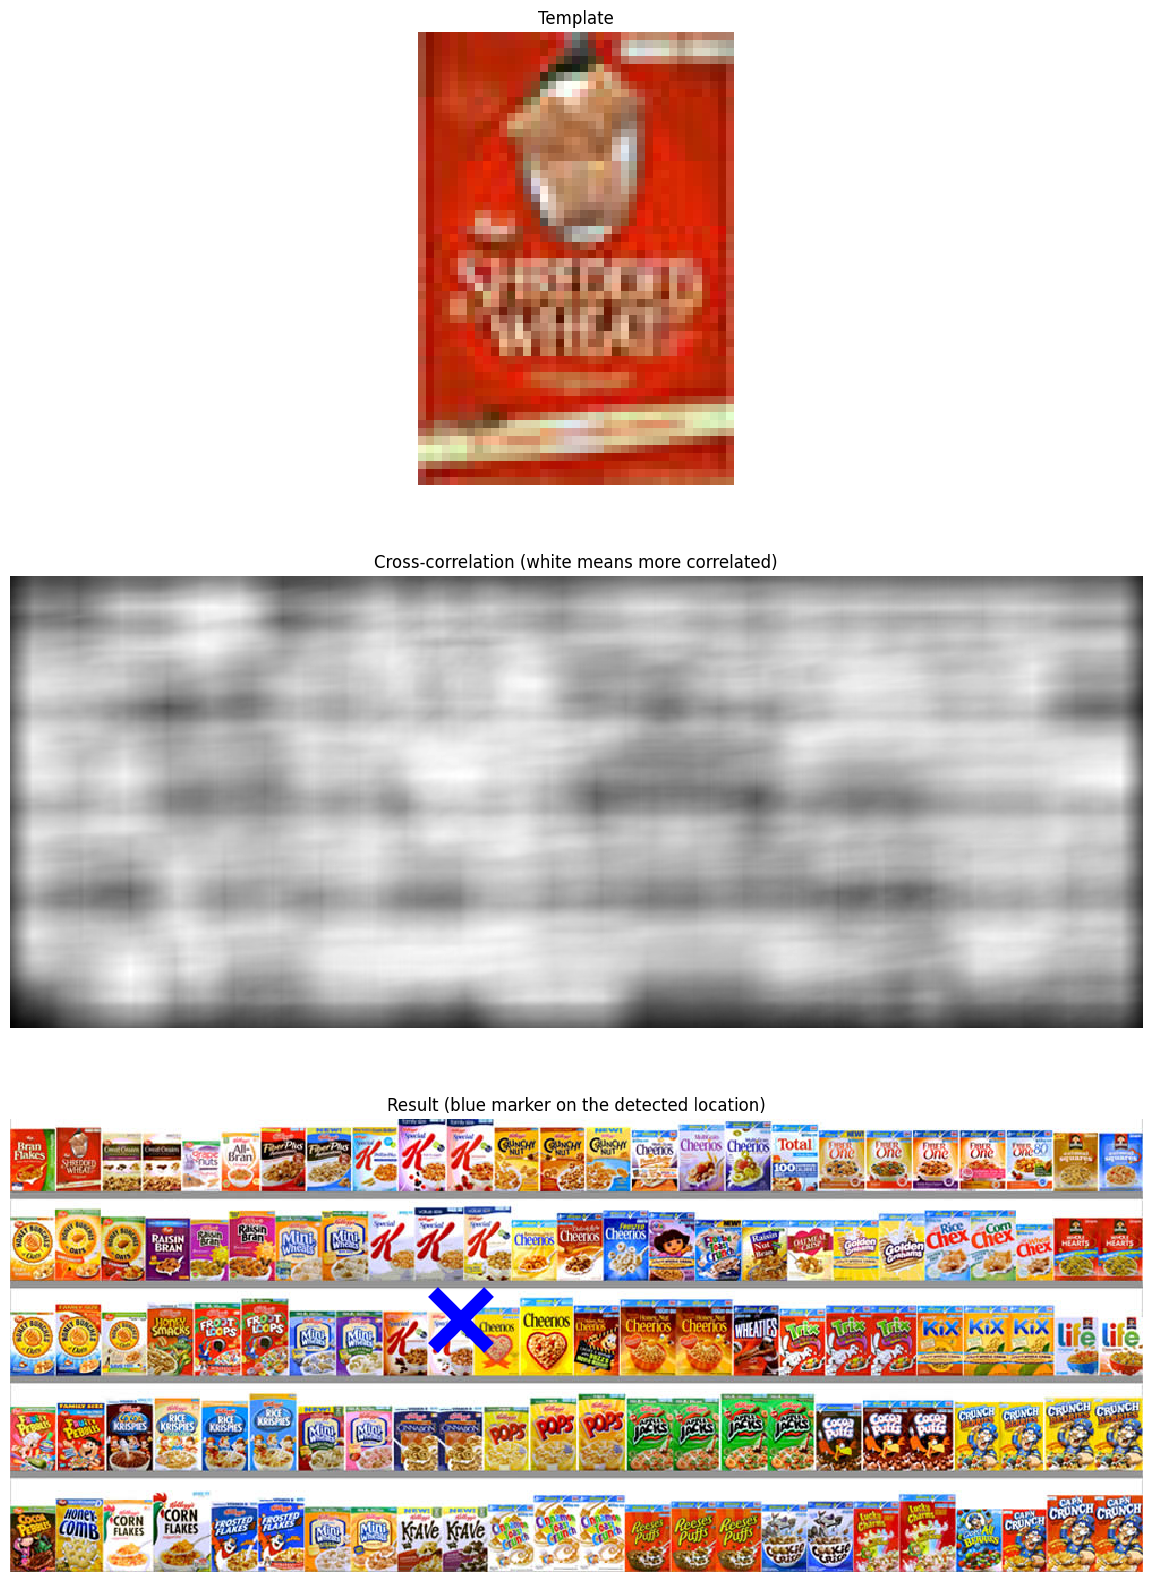

In [424]:
# Load template and image in grayscale
img = io.imread('shelf.jpg')
img_gray = io.imread('shelf.jpg', as_gray=True)
temp = io.imread('template.jpg')
temp_gray = io.imread('template.jpg', as_gray=True)

# Perform cross-correlation between the image and the template
out = cross_correlation(img_gray, temp_gray)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(25,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at the detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()

#### Interpretation
How does the output of cross-correlation filter look? Explain what problems there might be with using a raw template as a filter.

---
### 2.2 Zero-mean cross-correlation (6 points)
A solution to this problem is to subtract the mean value of the template so that it has zero mean.

Implement **`zero_mean_cross_correlation`** function and run the code below.

**If your implementation is correct, you should see the blue cross centered over the correct cereal box.**

In [425]:
def zero_mean_cross_correlation(f, g):
    """ Zero-mean cross-correlation of image f and template g.

    Subtract the mean of g from g so that its mean becomes zero.

    Hint: you should look up useful numpy functions online for calculating the mean.

    Args:
        f: numpy array of shape (Hf, Wf).
        g: numpy array of shape (Hg, Wg).

    Returns:
        out: numpy array of shape (Hf, Wf).
    """

    kernel = g - np.mean(g)
    kernel = np.flip(kernel)
    return conv_fast(f, kernel)


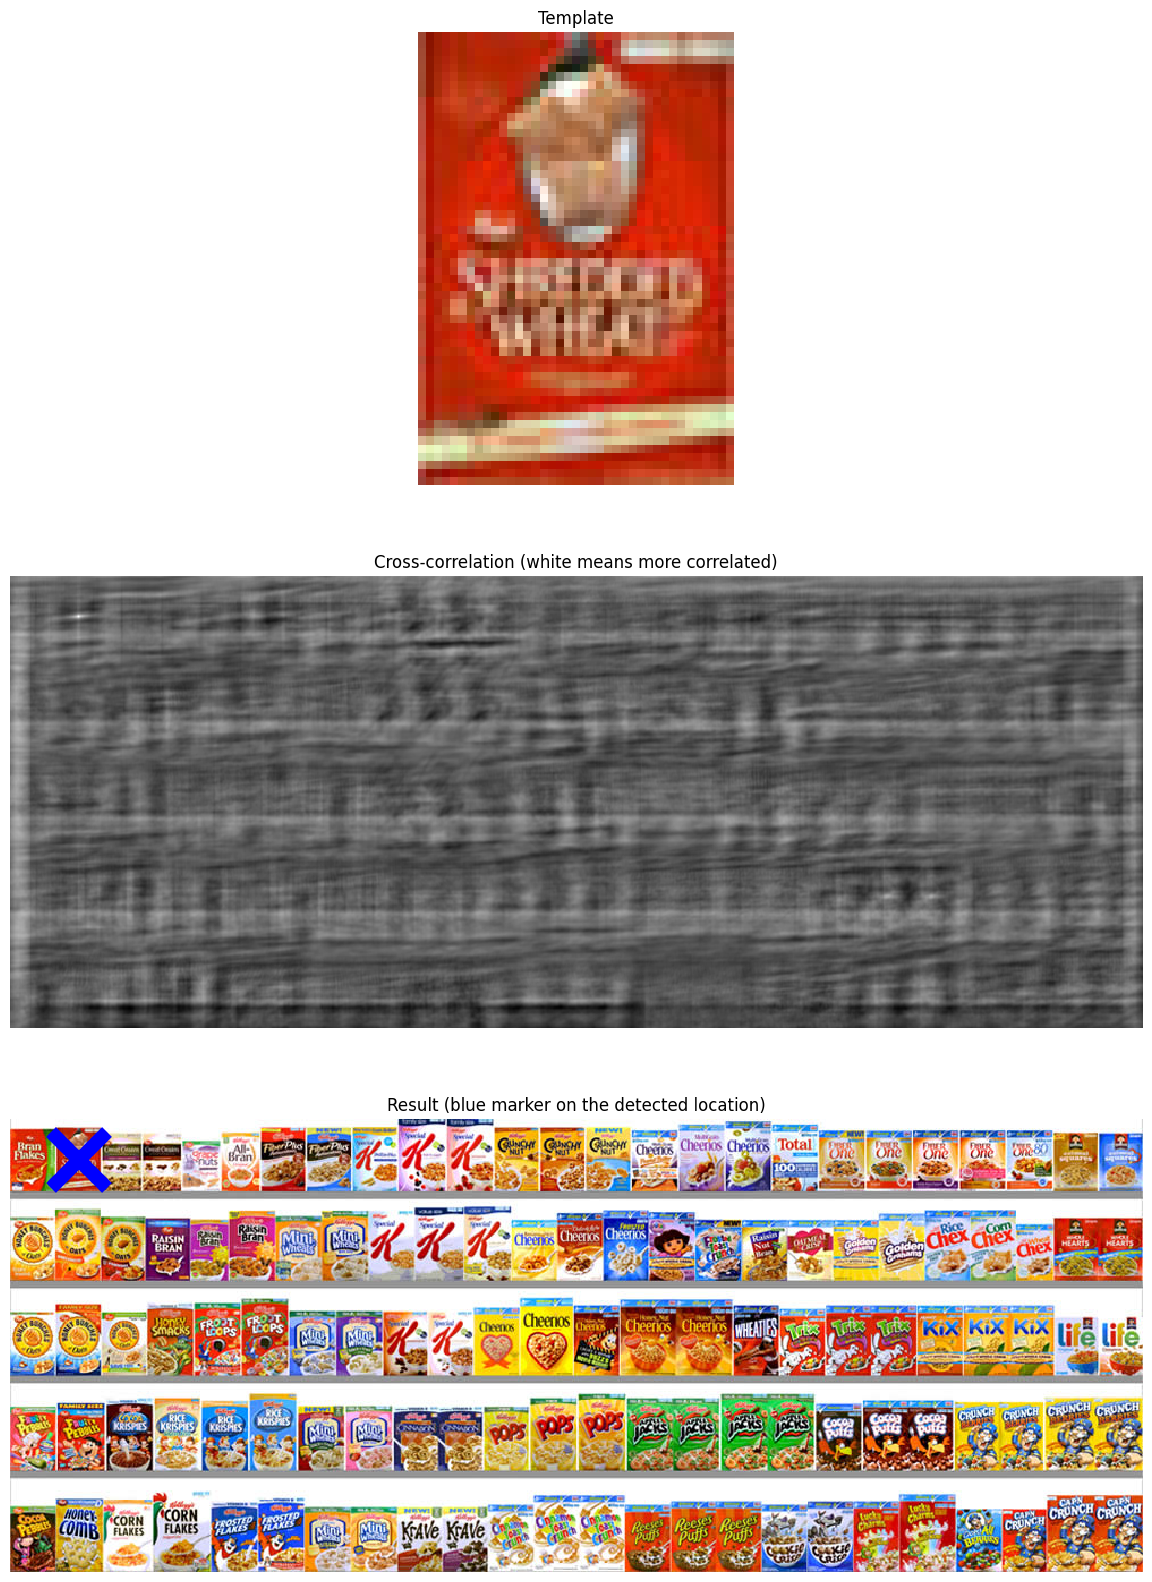

In [426]:
# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_gray, temp_gray)

# Find the location with maximum similarity
y,x = np.unravel_index(out.argmax(), out.shape)

# Display product template
plt.figure(figsize=(30,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at the detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


You can also determine whether the product is present with appropriate scaling and thresholding.

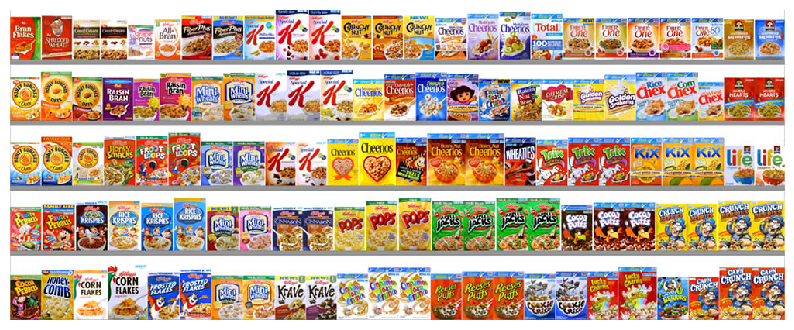

The product is on the shelf


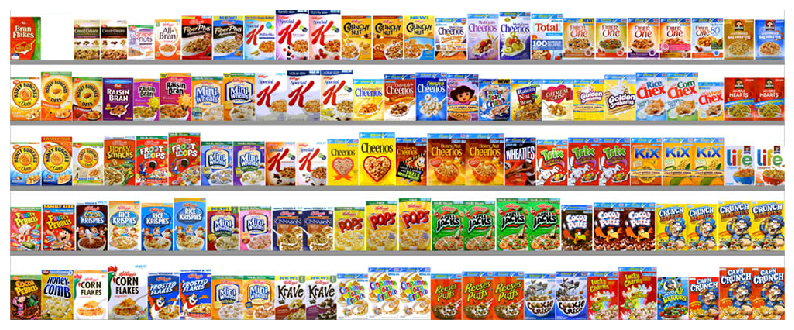

The product is not on the shelf


In [427]:
def check_product_on_shelf(shelf, product):
    out = zero_mean_cross_correlation(shelf, product)
    
    # Scale output by the size of the template
    out = out / float(product.shape[0]*product.shape[1])
    
    # Threshold output (this is arbitrary, you would need to tune the threshold for a real application)
    out = out > 0.025
    
    if np.sum(out) > 0:
        print('The product is on the shelf')
    else:
        print('The product is not on the shelf')

# Load image of the shelf without the product
img2 = io.imread('shelf_soldout.jpg')
img2_gray = io.imread('shelf_soldout.jpg', as_gray=True)

plt.imshow(img)
plt.axis('off')
plt.show()
check_product_on_shelf(img_gray, temp_gray)

plt.imshow(img2)
plt.axis('off')
plt.show()
check_product_on_shelf(img2_gray, temp_gray)

---
### 2.3 Normalized Cross-correlation (12 points)
One day the light near the shelf goes out and the product tracker starts to malfunction. The `zero_mean_cross_correlation` is not robust to change in lighting condition. The code below demonstrates this.

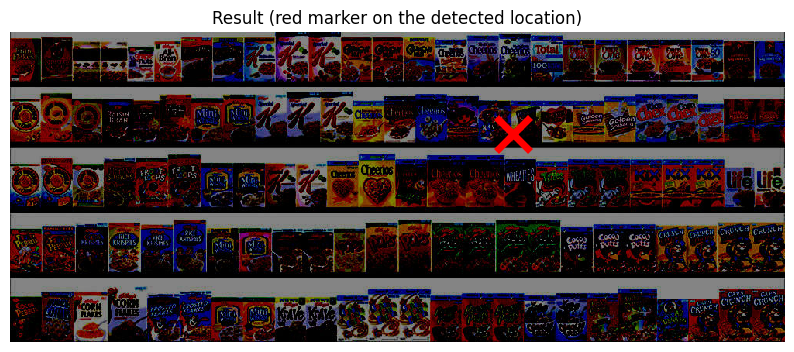

In [428]:
# Load image
img = io.imread('shelf_dark.jpg')
img_gray = io.imread('shelf_dark.jpg', as_gray=True)

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_gray, temp_gray)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

A solution is to normalize the pixels of the image and template at every step before comparing them. This is called **normalized cross-correlation**.

The mathematical definition for normalized cross-correlation of $f$ and template $g$ is:
$$(g \star f)[m,n]=\sum_{i,j} \frac{g[i, j]-\overline{g}}{\sigma_g} \cdot \frac{f[m + i, n + j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}}$$

where:
- $f_{m,n}$ is the patch image at position $(m,n)$
- $\overline{f_{m,n}}$ is the mean of the patch image $f_{m,n}$
- $\sigma_{f_{m,n}}$ is the standard deviation of the patch image $f_{m,n}$ 
- $\overline{g}$ is the mean of the template $g$
- $\sigma_g$ is the standard deviation of the template $g$

Implement the **`normalized_cross_correlation`** function and run the code below.

In [429]:
def normalized_cross_correlation(f, g):
    """ Normalized cross-correlation of image f and template g.

    Normalize the subimage of f and the template g at each step
    before computing the weighted sum of the two.

    Hint: you should look up useful numpy functions online for calculating 
          the mean and standard deviation.

    Args:
        f: numpy array of shape (Hf, Wf).
        g: numpy array of shape (Hg, Wg).

    Returns:
        out: numpy array of shape (Hf, Wf).
    """

    g_mean = np.mean(g)
    g_std = np.std(g)

    Hi, Wi = f.shape
    Hk, Wk = g.shape

    pad_h, pad_w = Hk // 2, Wk // 2

    padded = zero_pad(f, pad_h, pad_w) # Pad the image

    out = np.zeros((Hi, Wi))

    for i in range(Hi):
        for j in range(Wi):
            region = padded[i:i+Hk, j:j+Wk]
            f_mean = np.mean(region)
            f_std = np.std(region)
            out[i, j] = np.sum(np.multiply((g - g_mean) / g_std, (region - f_mean) / f_std))

    return out

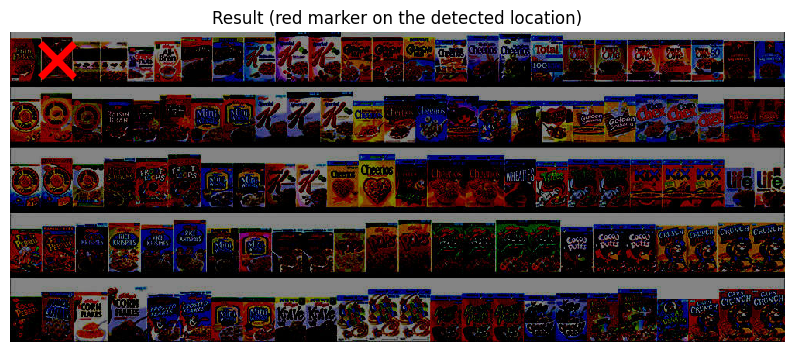

In [430]:
# Perform a normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_gray, temp_gray)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

---
## Part 3: Canny Edge Detector (85 points)
In this part, you are going to implement a Canny edge detector. The Canny edge detection algorithm can be broken down in to five steps:
1. Smoothing
2. Finding gradients
3. Non-maximum suppression
4. Double thresholding
5. Edge tracking by hysterisis

### 3.1 Smoothing (10 points)
#### Implementation (5 points)
We first smooth the input image by convolving it with a Gaussian kernel. The equation for a Gaussian kernel of size $(2k+1)\times(2k+1)$ is given by:

$$h_{ij}=\frac{1}{2\pi\sigma^2}\exp{\Bigl(-\frac{(i-k)^2+(j-k)^2}{2\sigma^2}\Bigr)}, 0\leq i,j < 2k+1$$

Implement **`gaussian_kernel`** and run the code below.

In [431]:
def gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size))
    k = size // 2

    for i in range(size):
        for j in range(size):
            kernel[i, j] = np.exp(-((i - k) ** 2 + (j - k) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)

    return kernel

In [432]:
# Define 3x3 Gaussian kernel with std = 1
kernel = gaussian_kernel(3, 1)
kernel_test = np.array(
    [[ 0.05854983, 0.09653235, 0.05854983],
     [ 0.09653235, 0.15915494, 0.09653235],
     [ 0.05854983, 0.09653235, 0.05854983]]
)

# Test Gaussian kernel
if not np.allclose(kernel, kernel_test):
    print('Incorrect values! Please check your implementation.')

Implement **`conv`** and run the code below. This time, ensure that you're using **edge** padding (as opposed to zero-padding, as done in `conv_fast`). 

Hint: Check out `np.pad`, and the various `mode`s that it takes.

In [433]:
def conv(image, kernel):
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    kernel = np.flip(kernel)

    # For this assignment, we will use edge values to pad the images.
    # Zero padding will make derivatives at the image boundary very big,
    # whereas we want to ignore the edges at the boundary.
    pad_width0 = Hk // 2
    pad_width1 = Wk // 2
    pad_width = ((pad_width0, pad_width0), (pad_width1, pad_width1))
    padded = np.pad(image, pad_width, mode='edge')

    for i in range(Hi):
        for j in range(Wi):
            region = padded[i:i+Hk, j:j+Wk]
            out[i, j] = np.sum(region * kernel)

    return out

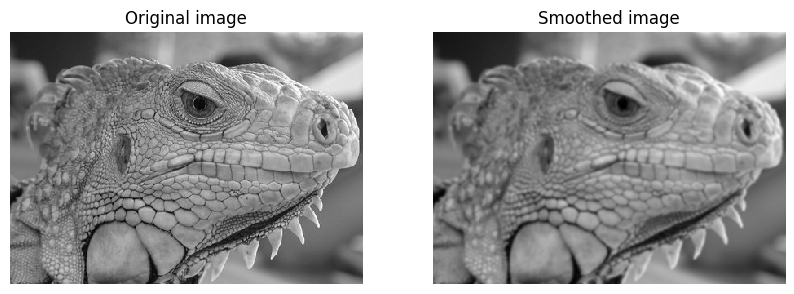

In [434]:
# Test with different kernel_size and sigma
kernel_size = 5
sigma = 1.4

# Load image
img = io.imread('iguana.png', as_gray=True)

# Define 5x5 Gaussian kernel with std = sigma
kernel = gaussian_kernel(kernel_size, sigma)

# Convolve image with kernel to achieve a smoothed effect
smoothed = conv(img, kernel)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(smoothed)
plt.title('Smoothed image')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the effect of changing kernel_size and sigma?

**Your Answer:** Write your solution in this markdown cell.

Sigma controls the falloff of weights from the center pixel. Larger sigma -> more smoothing (neighboring pixels contribute more heavily to the average).

Kernel size determines the discrete window over which the Gaussian is applied. Controls 'over how many pixels' the blur is computed.

### 3.2 Finding gradients (15 points)
The gradient of a 2D scalar function $I:\mathbb{R}^2\rightarrow{\mathbb{R}}$ in Cartesian coordinate is defined by:

$$\nabla{I(x,y)}=\bigl[\frac{\partial{I}}{\partial{x}},\frac{\partial{I}}{\partial{y}}\bigr],$$

where

$$
\frac{\partial{I(x,y)}}{\partial{x}}=\lim_{\Delta{x}\to{0}}\frac{I(x+\Delta{x},y)-I(x,y)}{\Delta{x}} \\
\frac{\partial{I(x,y)}}{\partial{y}}=\lim_{\Delta{y}\to{0}}\frac{I(x,y+\Delta{y})-I(x,y)}{\Delta{y}}.
$$

In case of images, we can approximate the partial derivatives by taking differences at one pixel intervals:

$$
\frac{\partial{I(x,y)}}{\partial{x}}\approx{\frac{I(x+1,y)-I(x-1,y)}{2}} \\
\frac{\partial{I(x,y)}}{\partial{y}}\approx{\frac{I(x,y+1)-I(x,y-1)}{2}}
$$

Note that the partial derivatives can be computed by convolving the image $I$ with some appropriate kernels $D_x$ and $D_y$:

$$
\frac{\partial{I}}{\partial{x}}\approx{I*D_x}=G_x \\
\frac{\partial{I}}{\partial{y}}\approx{I*D_y}=G_y
$$

#### Implementation (5 points)
Find the kernels $D_x$ and $D_y$ and implement **`partial_x`** and **`partial_y`** using `conv` defined below.

*- Hint: Remeber that convolution flips the kernel.*

In [435]:
def partial_x(img):
    kernel = np.array([[0.5, 0.0, -0.5]])
    return conv(img, kernel)

def partial_y(img):
    kernel = np.array([[0.5], [0.0], [-0.5]])
    return conv(img, kernel)


In [436]:
# Test input
I = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [0, 0, 0]]
)

# Expected outputs
I_x_test = np.array(
    [[ 0, 0, 0],
     [ 0.5, 0, -0.5],
     [ 0, 0, 0]]
)

I_y_test = np.array(
    [[ 0, 0.5, 0],
     [ 0, 0, 0],
     [ 0, -0.5, 0]]
)

# Compute partial derivatives
I_x = partial_x(I)
I_y = partial_y(I)

# Test correctness of partial_x and partial_y
if not np.all(I_x == I_x_test):
    print('partial_x incorrect')
    
if not np.all(I_y == I_y_test):
    print('partial_y incorrect')

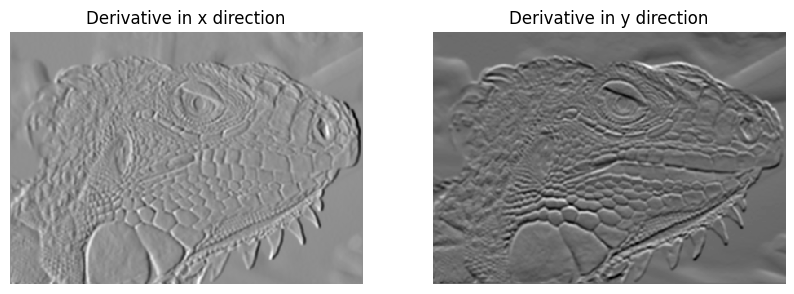

In [437]:
# Compute partial derivatives of smoothed image
Gx = partial_x(smoothed)
Gy = partial_y(smoothed)

plt.subplot(1,2,1)
plt.imshow(Gx)
plt.title('Derivative in x direction')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(Gy)
plt.title('Derivative in y direction')
plt.axis('off')

plt.show()

#### Question (5 points)
What is the reason for performing smoothing prior to computing the gradients?

**Your Answer:** Write your solution in this markdown cell.

It reduces noise.

#### Implementation (5 points)
Now, we can compute the magnitude and direction of gradient with the two partial derivatives:

$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}} \\
\Theta = arctan\bigl(\frac{G_{y}}{G_{x}}\bigr)
$$

Implement **`gradient`** below which takes in an image and outputs $G$ and $\Theta$.

In [438]:
def gradient(img):
    dx = partial_x(img)
    dy = partial_y(img)

    G = np.sqrt(np.square(dx) + np.square(dy))
    theta = np.arctan2(dy, dx)
    theta = np.rad2deg(theta)
    theta = theta % 360

    return G, theta


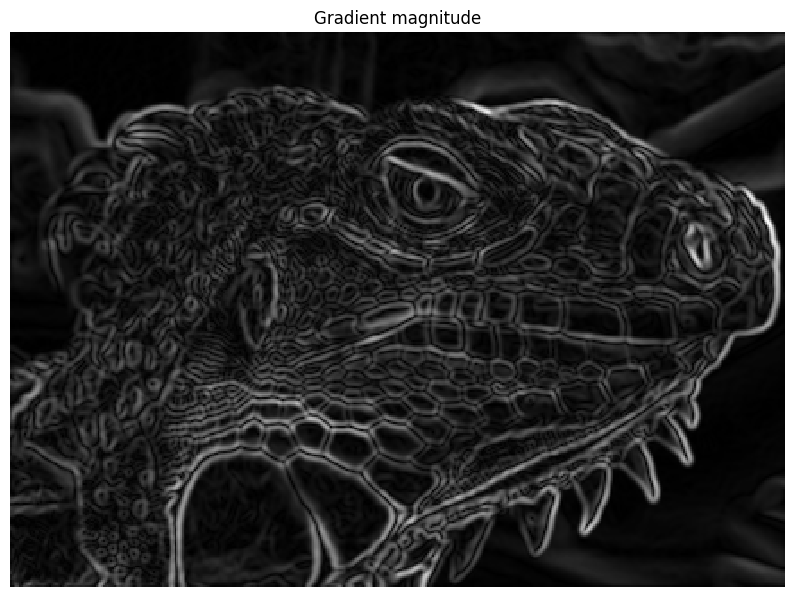

In [439]:
G, theta = gradient(smoothed)

if not np.all(G >= 0):
    print('Magnitude of gradients should be non-negative.')
    
if not np.all((theta >= 0) * (theta < 360)):
    print('Direction of gradients should be in range 0 <= theta < 360')

plt.imshow(G)
plt.title('Gradient magnitude')
plt.axis('off')
plt.show()

### 3.3 Non-maximum suppression (15 points)
You should be able to see that the edges extracted from the gradient of the smoothed image are quite thick and blurry. The purpose of this step is to convert the "blurred" edges into "sharp" edges. Basically, this is done by preserving all local maxima in the gradient image and discarding everything else. The algorithm is for each pixel (x,y) in the gradient image:
1. Round the gradient direction $\Theta[y,x]$ to the nearest 45 degrees, corresponding to the use of an 8-connected neighbourhood.

2. Compare the edge strength of the current pixel with the edge strength of the pixel in the positive and negative gradient directions. For example, if the gradient direction is south (theta=90), compare with the pixels to the north and south.

3. If the edge strength of the current pixel is the largest; preserve the value of the edge strength. If not, suppress (i.e. remove) the value.

Implement **`non_maximum_suppression`** below.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [463]:
def non_maximum_suppression(G, theta):
    H, W = G.shape
    out = np.zeros((H, W))

    theta = (np.floor((theta + 22.5) / 45) * 45) % 180

    for i in range(0, H):
        for j in range(0, W):
            a = theta[i, j]

            if a == 0:
                q = G[i, j + 1] if j + 1 < W else 0
                r = G[i, j - 1] if j - 1 >= 0 else 0
            elif a == 45:
                q = G[i - 1, j - 1] if i - 1 >= 0 and j - 1 >= 0 else 0
                r = G[i + 1, j + 1] if i + 1 < H and j + 1 < W else 0
            elif a == 90:
                q = G[i - 1, j] if i - 1 >= 0 else 0
                r = G[i + 1, j] if i + 1 < H else 0
            elif a == 135:
                q = G[i - 1, j + 1] if i - 1 >= 0 and j + 1 < W else 0
                r = G[i + 1, j - 1] if i + 1 < H and j - 1 >= 0 else 0
            else:
                q = 0; r = 0

            if G[i, j] > q and G[i, j] > r:
                out[i, j] = G[i, j]

    return out


In [459]:
# Test input
g = np.array(
    [[0.4, 0.5, 0.6],
     [0.3, 0.5, 0.7],
     [0.4, 0.5, 0.6]]
)

# Print out non-maximum suppressed output
# varying theta
for angle in range(0, 180, 45):
    #print('Thetas:', angle)
    t = np.ones((3, 3)) * angle # Initialize theta
    print(non_maximum_suppression(g, t))

[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]
[[0.  0.  0.6]
 [0.  0.  0.7]
 [0.4 0.5 0.6]]
[[0.4 0.  0. ]
 [0.  0.  0.7]
 [0.4 0.  0. ]]
[[0.4 0.5 0.6]
 [0.  0.  0.7]
 [0.  0.  0.6]]


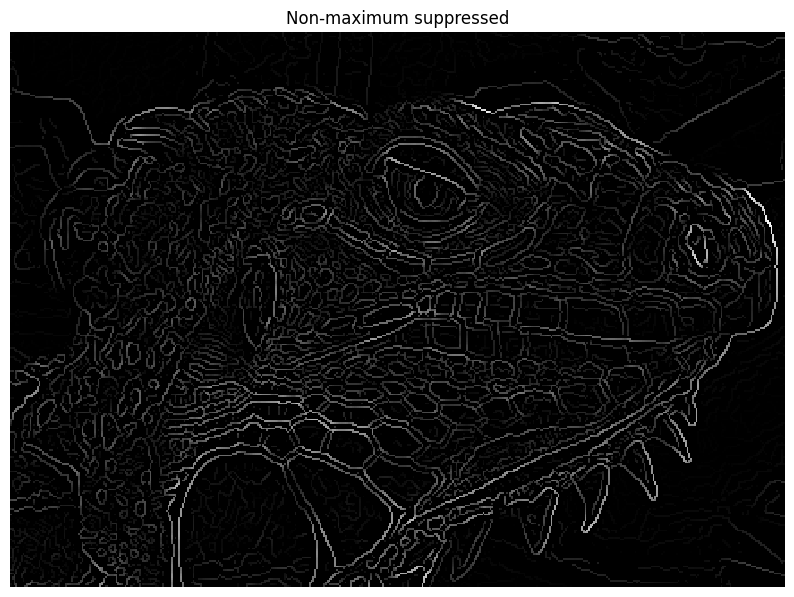

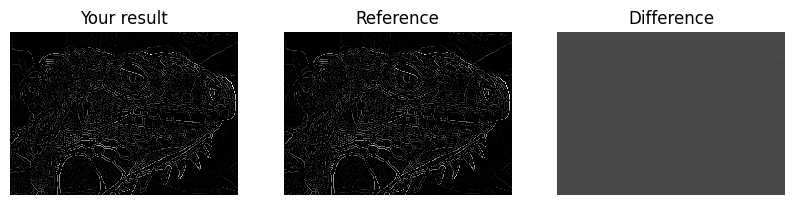

np.float64(0.004954806714090564)

In [464]:
nms = non_maximum_suppression(G, theta)
plt.imshow(nms)
plt.title('Non-maximum suppressed')
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(nms)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_non_max_suppressed.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(nms - reference)
plt.title('Difference')
plt.axis('off')
plt.show()

np.amax(nms-reference)

### 3.4 Double Thresholding (20 points)

The edge-pixels remaining after the non-maximum suppression step are (still) marked with their strength pixel-by-pixel. Many of these will probably be true edges in the image, but some may be caused by noise or color variations, for instance, due to rough surfaces. The simplest way to discern between these would be to use a threshold, so that only edges stronger that a certain value would be preserved. The Canny edge detection algorithm uses double thresholding. Edge pixels stronger than the high threshold are marked as strong; edge pixels weaker than the low threshold are suppressed and edge pixels between the two thresholds are marked as weak.

Implement **`double_thresholding`** below.

In [476]:
def double_thresholding(img, high, low):
    strong_edges = np.zeros(img.shape, dtype=np.bool)
    weak_edges = np.zeros(img.shape, dtype=np.bool)

    weak_edges = (img < high) & (img > low)
    strong_edges = img > high

    return strong_edges, weak_edges

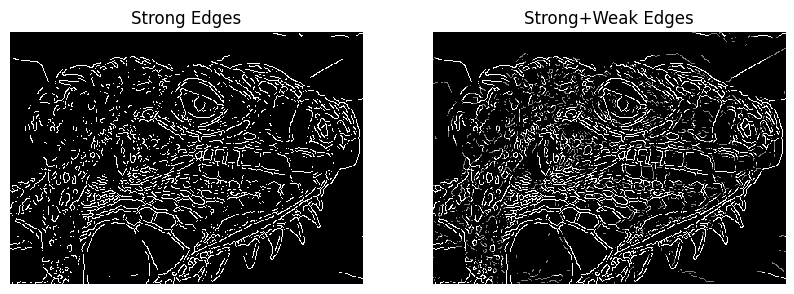

In [477]:
low_threshold = 0.02
high_threshold = 0.03

strong_edges, weak_edges = double_thresholding(nms, high_threshold, low_threshold)
assert(np.sum(strong_edges & weak_edges) == 0)

edges=strong_edges * 1.0 + weak_edges * 0.5

plt.subplot(1,2,1)
plt.imshow(strong_edges)
plt.title('Strong Edges')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edges)
plt.title('Strong+Weak Edges')
plt.axis('off')

plt.show()

### 3.5 Edge tracking (15 points)

Strong edges are interpreted as “certain edges”, and can immediately be included in the final edge image. Consider its neighbors iteratively then declare it an 'edge pixel' if it is connected to a 'strong edge pixel' directly or via pixels between Low and High. The logic is of course that noise and other small variations are unlikely to result in a strong edge (with proper adjustment of the threshold levels). Thus strong edges will (almost) only be due to true edges in the original image. The weak edges can either be due to true edges or noise/color variations. The latter type will probably be distributed independently of edges on the entire image, and thus only a small amount will be located adjacent to strong edges. Weak edges due to true edges are much more likely to be connected directly to strong edges.

Implement **`link_edges`** below.

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [478]:
from collections import deque


# a helper function for you to use:
def get_neighbors(y, x, H, W):
    """ Return indices of valid neighbors of (y, x).

    Return indices of all the valid neighbors of (y, x) in an array of
    shape (H, W). An index (i, j) of a valid neighbor should satisfy
    the following:
        1. i >= 0 and i < H
        2. j >= 0 and j < W
        3. (i, j) != (y, x)

    Args:
        y, x: location of the pixel.
        H, W: size of the image.
    Returns:
        neighbors: list of indices of neighboring pixels [(i, j)].
    """

    neighbors = []

    for i in (y - 1, y, y + 1):
        for j in (x - 1, x, x + 1):
            if 0 <= i < H and 0 <= j < W:
                if i == y and j == x:
                    continue
                neighbors.append((i, j))

    return neighbors


def link_edges(strong_edges, weak_edges):
    """ Find weak edges connected to strong edges and link them.

    Iterate over each pixel in strong_edges and perform the breadth first
    search across the connected pixels in weak_edges to link them.
    Here we consider a pixel (a, b) is connected to a pixel (c, d)
    if (a, b) is one of the eight neighboring pixels of (c, d).

    Args:
        strong_edges: binary image of shape (H, W).
        weak_edges: binary image of shape (H, W).

    Returns:
        edges: numpy boolean array of shape(H, W).
    """

    H, W = strong_edges.shape
    indices = np.stack(np.nonzero(strong_edges)).T
    edges = np.zeros((H, W), dtype=np.bool)

    # Make new instances of arguments to leave the original references intact
    weak_edges = np.copy(weak_edges)
    edges = np.copy(strong_edges)

    for x in range(H):
        for y in range(W):
            if strong_edges[x, y]:
                q = deque([(x, y)])
                while len(q) > 0:
                    i, j = q.pop()
                    for a, b in get_neighbors(i, j, H, W):
                        if weak_edges[a, b] and not edges[a, b]:
                            edges[a, b] = True
                            q.append((a, b))

    return edges

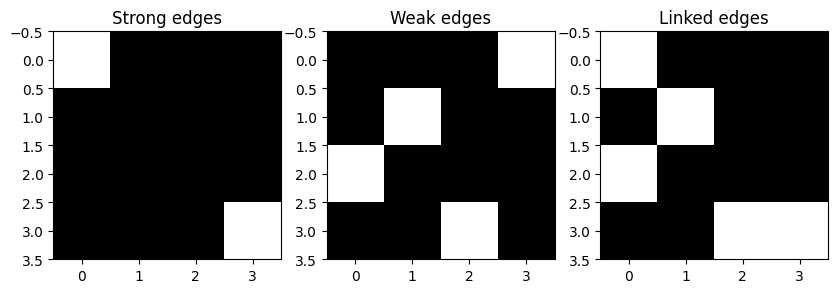

In [479]:
test_strong = np.array(
    [[1, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 0],
     [0, 0, 0, 1]],
    dtype=np.bool
)

test_weak = np.array(
    [[0, 0, 0, 1],
     [0, 1, 0, 0],
     [1, 0, 0, 0],
     [0, 0, 1, 0]],
    dtype=np.bool
)

test_linked = link_edges(test_strong, test_weak)

plt.subplot(1, 3, 1)
plt.imshow(test_strong)
plt.title('Strong edges')

plt.subplot(1, 3, 2)
plt.imshow(test_weak)
plt.title('Weak edges')

plt.subplot(1, 3, 3)
plt.imshow(test_linked)
plt.title('Linked edges')
plt.show()

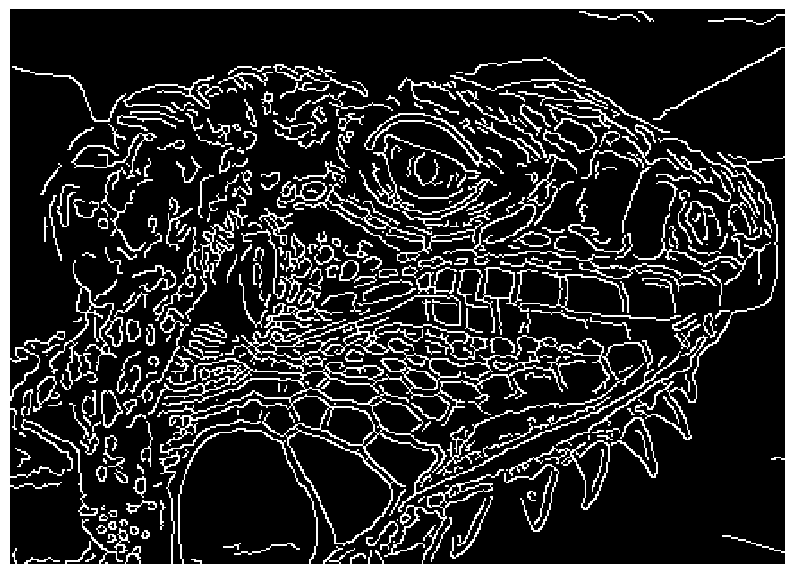

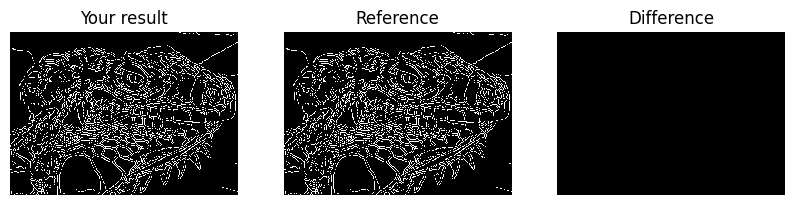

In [480]:
edges = link_edges(strong_edges, weak_edges)

plt.imshow(edges)
plt.axis('off')
plt.show()

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_edge_tracking.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

### 3.6 Canny edge detector
Implement **`canny`** below using the functions you have implemented so far. Test edge detector with different parameters.

Here is an example of the output:

![iguana_edges.png](iguana_edges.png)

We provide the correct output and the difference between it and your result for debugging purposes.  If you see white spots in the Difference image, you should check your implementation.

In [481]:
def canny(img, kernel_size=5, sigma=1.4, high=20, low=15):
    """ Implement canny edge detector by calling functions above.

    Args:
        img: binary image of shape (H, W).
        kernel_size: int of size for kernel matrix.
        sigma: float for calculating kernel.
        high: high threshold for strong edges.
        low: low threashold for weak edges.
    Returns:
        edge: numpy array of shape(H, W).
    """

    # First, smooth the image
    g_kernel = gaussian_kernel(kernel_size, sigma)
    smoothed = conv(img, g_kernel)

    # Find the intensity gradients of the image
    G, theta = gradient(smoothed)

    # Apply gradient magnitude thresholding
    nms = non_maximum_suppression(G, theta)

    # Apply a double threshold
    strong_edges, weak_edges = double_thresholding(nms, high, low)

    # Link the edges
    edge = link_edges(strong_edges, weak_edges)

    return edge

(310, 433)


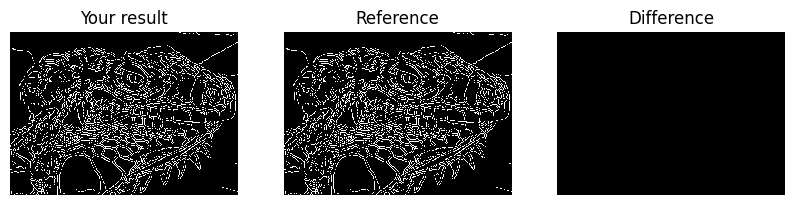

In [488]:
# Load image
img = io.imread('iguana.png', as_gray=True)

# Run Canny edge detector
edges = canny(img, kernel_size=5, sigma=1.4, high=0.03, low=0.02)
print (edges.shape)

plt.subplot(1, 3, 1)
plt.imshow(edges)
plt.axis('off')
plt.title('Your result')

plt.subplot(1, 3, 2)
reference = np.load('references/iguana_canny.npy')
plt.imshow(reference)
plt.axis('off')
plt.title('Reference')

plt.subplot(1, 3, 3)
plt.imshow(edges ^ reference)
plt.title('Difference')
plt.axis('off')
plt.show()

### 3.7 Question (10 points)

![1.7a.png](1.7a.png)

**(a)** Suppose that the Canny edge detector successfully detects an edge in an image. The edge (see the figure above) is then rotated by θ, where the relationship between a point on the original edge $(x, y)$ and a point on the rotated edge $(x', y')$ is defined as

$$
x'=x\cos{\theta}\\
y'=x\sin{\theta}
$$

Will the rotated edge be detected using the same Canny edge detector? Provide either a mathematical proof or a counter example.

*- Hint 1: The detection of an edge by the Canny edge detector depends only on the magnitude of its derivative. The derivative at point (x, y) is determined by its components along the x and y directions. Think about how these magnitudes have changed because of the rotation.* <br>
*- Hint 2: You can assume that (x,y) lies on the x-axis, i.e., y = 0.* <br>
*- Hint 3: You can also assume that G_x(x, y) = 0. In other words, the gradient which is perpendicular to the direction of the unrotated edge at (x, y) only has a vertical component and thus only consists of G_y(x, y).*

**Your Answer:** Write your solution in this markdown cell.

\begin{aligned}
x &= x' \cos\theta - y' \sin\theta, \\
y &= x' \sin\theta + y' \cos\theta.
\end{aligned}

Gradient components in the rotated coordinates are:
\begin{aligned}
G_{x'}
  &= \frac{\partial I}{\partial x'}
   = \frac{\partial I}{\partial x}\frac{\partial x}{\partial x'}
    + \frac{\partial I}{\partial y}\frac{\partial y}{\partial x'} \\
  &= G_x \cos\theta + G_y \sin\theta, \\[6pt]
G_{y'}
  &= \frac{\partial I}{\partial y'}
   = \frac{\partial I}{\partial x}\frac{\partial x}{\partial y'}
    + \frac{\partial I}{\partial y}\frac{\partial y}{\partial y'} \\
  &= -G_x \sin\theta + G_y \cos\theta.
\end{aligned}

In matrix form:

$$
\begin{pmatrix}
G_{x'} \\[2pt] G_{y'}
\end{pmatrix}
=
\begin{pmatrix}
\cos\theta & \sin\theta \\
-\sin\theta & \cos\theta
\end{pmatrix}
\begin{pmatrix}
G_x \\[2pt] G_y
\end{pmatrix}.
$$

Because this is an orthonormal rotation matrix, it preserves the Euclidean norm:

$$
G_{x'}^2 + G_{y'}^2 = G_x^2 + G_y^2.
$$

**Rotation does not change the gradient magnitude, so the same Canny detector (same magnitude thresholds) will detect the rotated edge.**

**(b)** After running the Canny edge detector on an image, you notice that long edges are broken into short segments separated by gaps. In addition, some spurious edges appear. For each of the two thresholds (low and high) used in hysteresis thresholding, explain how you would adjust the threshold (up or down) to address both problems. Assume that a setting exists for the two thresholds that produces the desired result. Briefly explain your answer.

**Your Answer:** Write your solution in this Markdown cell.

For long edges broken down into short segments, lower the low threshold. This creates more weak-edge pixels, so weak segments between strong segments can be linked

For spurious edges, raise the high threshold. Fewer pixels qualify as strong seeds, so isolated noisy responses are less likely to be promoted into final edges.